## Graph

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from heapq import *

In [2]:
def MST(G):
    # sort edges weight in descending order
    h = []
    for u,v,d in G.edges(data=True):
        heappush(h, (d['weight'],u,v))
    heapsort = [heappop(h) for i in range(len(h))]
    heapsort.reverse()

    # kruskal MST algorithm
    def find_subtree(parent, i):
        # i represents index of nodes
        if parent[i] == i:
            return i
        return find_subtree(parent, parent[i])

    res = nx.Graph()
    parent = [j for j in range(len(G.nodes))]
    subtree_sizes = [0]*len(G.nodes)
    i = 0
    e = 0 # number of edges in MST

    while e<(len(G.nodes)-1):
        w, u, v = heapsort[i]
        i += 1
        u_index = list(G.nodes).index(u)
        v_index = list(G.nodes).index(v)
        x = find_subtree(parent, u_index)
        y = find_subtree(parent, v_index)
        # if u and v belongs to different subtree
        if x!=y:
            e += 1
            res.add_edge(u, v, weight = w)
            # connect two trees
            parent[y] = x
    return res

In [3]:
# get correlation matrix file names
data_folder = "Data/Corr_Mat"
file_path_list = os.listdir(data_folder)

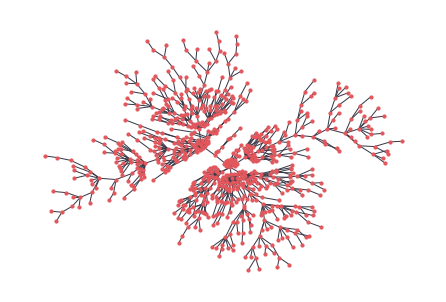

In [4]:
for file in file_path_list:
    # get correlation matrix
    corr_mat = pd.read_csv(data_folder+"/"+file, index_col=0)

    # draw graph based on adjacency matrix, whic is the correlation of residuals
    # i.e., the distance between two nodes are defined as the absolute value of
    # their correlations
    # more close two nodes are, more common risk factors they share
    G0 = nx.from_pandas_adjacency(np.abs(corr_mat))
    G0_MST = MST(G0)
    nx.draw(G0_MST, with_labels=False, node_size=10, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G0_MST))
    break